In [1]:
import math
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam

2023-07-19 17:09:00.880988: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 17:09:01.470119: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Define the Q-Network model
def create_q_network(input_shape, action_space):
    model = Sequential(
        [
            # Dropout(0.1, input_shape=input_shape),
            InputLayer(shape=input_shape),
            Dense(32, activation='relu'),
            Dense(32, activation='relu'),
            Dense(action_space, activation='linear')
        ]
    )
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

In [3]:
def euclidean_distance(p1, p2):
    return math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

In [4]:
class ENV():
    def __init__(self):
        self.steps = 0
        self.env_col = 6
        self.env_row = 6
        self.state = (3, 3)
        self.action_space = 4
        self.reward = 0
        self.done = False
        self.goal = (1, 1)

    def reset(self):
        # self.goal = np.random.randint(0, min(self.env_col, self.env_row), size=2)
        self.state = np.random.randint(0, min(self.env_col, self.env_row), size=2)
        self.reward = 0
        self.done = False
        self.steps = 0
        return self.state
    
    def step(self, action):
        prev_state = self.state
        self.steps += 1
        if action == 0: # up
            self.state = (self.state[0], self.state[1] + 1)
        elif action == 1: # down
            self.state = (self.state[0], self.state[1] - 1)
        elif action == 2: # left
            self.state = (self.state[0] - 1, self.state[1])
        elif action == 3: # right
            self.state = (self.state[0] + 1, self.state[1])
        else:
            raise ValueError("Invalid action")
        # print(type(self.state), type(self.goal)) # debug
        if tuple(self.state) == tuple(self.goal):
            self.reward = 300
            self.done = True
            # self.goal = np.random.randint(0, min(self.env_col, self.env_row), size=2)
        elif self.state[0] < 0 or self.state[0] >= self.env_col or self.state[1] < 0 or self.state[1] >= self.env_row:
            self.reward = -200
            self.done = True
        elif self.steps >= 10:
            self.reward = -100
            self.done = True
        else:
            if euclidean_distance(self.state, self.goal) < euclidean_distance(prev_state, self.goal):
                self.reward = 5
            else:
                self.reward = -5
        return self.state, self.reward, self.done


In [5]:
#Define the DQN agent
class DQNAgent:
    def __init__(self, state_shape, action_space, goal):
        self.goal = goal
        self.state_shape = state_shape
        self.action_space = action_space
        self.memory = []
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1  # Exploration rate
        self.epsilon_decay = 0.995  # Decay rate for exploration rate
        self.epsilon_min = 0.01  # Minimum exploration rate
        self.learning_rate = 0.001  # Learning rate
        # self.model = create_q_network(state_shape, action_space) # state_shape = (2,)
        try:
            self.model = tf.keras.models.load_model('model_dqn_pt_to_pt_diff_start_diff_goal.h5') # loading the last saved model
        except:
            self.model = create_q_network((4,), action_space)

    def remember(self, state, goal, action, reward, next_state, done):
        self.memory.append((state, goal, action, reward, next_state, done))
        if len(self.memory) > 100:
            self.memory = self.memory[-100:]

    def act(self, state, test=False):
        if not test:
            if np.random.rand() < self.epsilon:
                return np.random.choice(self.action_space)
        # print("state in action: ",state)
        state_goal = np.concatenate((state, self.goal))
        state_goal = np.reshape(state_goal, (4,))
        state_goal = tf.convert_to_tensor(state_goal)
        state_goal = tf.expand_dims(state_goal, 0)
        # print("Predicting")
        q_values = self.model.predict(state_goal, verbose=0)
        return np.argmax(q_values[0])

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        # batch = np.random.choice(self.memory, batch_size, replace=False)
        batch_ch = np.random.choice(len(self.memory), batch_size, replace=False)
        batch = [self.memory[i] for i in batch_ch]
        for state, goal, action, reward, next_state, done in batch:
            state = np.reshape(state, self.state_shape)
            next_state = np.reshape(next_state, self.state_shape)
            target = reward
            if True:
                # print(next_state.shape)
                next_state_goal = np.concatenate((next_state, goal))
                next_state_goal = tf.convert_to_tensor(next_state_goal)
                next_state_goal = tf.expand_dims(next_state_goal, 0)
                # Q(s t , a t ) = Q(s t , a t )+α[r t+1 +γmax a Q(s t+1 , a)-Q(s t , a t )]
                # Use above equation to update the Q function
                target = reward + self.gamma * np.amax(self.model.predict(next_state_goal, verbose=0)[0])
                # target = reward + self.gamma * np.amax(self.model.predict(next_state_goal, verbose=0)[0])
            # print(state.shape)
            state_goal = np.concatenate((state, self.goal))
            state_goal = tf.convert_to_tensor(state_goal)
            state_goal = tf.expand_dims(state_goal, 0)
            # print("Predicting")
            target_f = self.model.predict(state_goal, verbose=0)
            target_f[0][action] += self.learning_rate * (target - target_f[0][action])
            # print(state_goal[0], state_goal[1])
            # print("Fitting model")
            self.model.fit(state_goal, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [6]:
# Initialize the environment and agent
state_shape = (2,)  # Example state shape, adjust according to your actual state representation # Only x and y coordinates
action_space = 4  # Example action space size, adjust according to your actual actions # 4 actions: up, down, left, right
env = ENV()
agent = DQNAgent(state_shape, action_space, env.goal)

2023-07-19 17:09:02.067750: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-07-19 17:09:02.067780: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: pradeep-Victus-by-HP-Laptop-16-e0xxx
2023-07-19 17:09:02.067785: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: pradeep-Victus-by-HP-Laptop-16-e0xxx
2023-07-19 17:09:02.067870: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.54.3
2023-07-19 17:09:02.067887: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.54.3
2023-07-19 17:09:02.067892: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.54.3


In [7]:
total_reward = []

In [8]:
#Training loop
num_episodes = 100  # Set the number of training episodes
batch_size = 32  # Set the batch size for replay
start_ep = 0 # Set the starting episode number
for episode in range(start_ep, start_ep + num_episodes):
    print("Episode: ", episode)
    state = env.reset()
    state = np.reshape(state, state_shape)
    done = False
    episode_reward = 0
    while not done:
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = np.reshape(next_state, state_shape)
        agent.remember(state, env.goal, action, reward, next_state, done)
        state = next_state
        episode_reward += reward
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
    # if agent.epsilon > agent.epsilon_min:
    #     agent.epsilon *= agent.epsilon_decay
    # if tuple(state) == tuple(env.goal): # If the agent reaches the goal position, we update the goal position
    #     env.goal = np.random.randint(0, min(env.env_col, env.env_row), size=2)
    #     agent.goal = env.goal
    total_reward.append(episode_reward)
    print("Episode reward: ", episode_reward)
    if agent.epsilon > agent.epsilon_min and len(agent.memory) > batch_size : # Decay the exploration rate
        agent.epsilon *= agent.epsilon_decay
    if episode%10 == 0: # Save the model every 10 episodes
        print("Saving model")
        agent.model.save(f"model_dqn_pt_to_pt_diff_start_diff_goal_{episode}.h5")
    agent.model.save(f"model_dqn_pt_to_pt_diff_start_diff_goal.h5") # Save the model after each episode



Episode:  0
Episode reward:  -75
Saving model
Episode:  1
Episode reward:  -200
Episode:  2
Episode reward:  -200
Episode:  3
Episode reward:  -205
Episode:  4
Episode reward:  -205
Episode:  5
Episode reward:  -195
Episode:  6
Episode reward:  -215
Episode:  7
Episode reward:  -105
Episode:  8
Episode reward:  -95
Episode:  9
Episode reward:  -200
Episode:  10
Episode reward:  -195
Saving model
Episode:  11
Episode reward:  -200
Episode:  12
Episode reward:  -200
Episode:  13
Episode reward:  -205
Episode:  14
Episode reward:  -85
Episode:  15
Episode reward:  -85
Episode:  16
Episode reward:  -85
Episode:  17
Episode reward:  315
Episode:  18
Episode reward:  -200
Episode:  19
Episode reward:  -205
Episode:  20
Episode reward:  -200
Saving model
Episode:  21
Episode reward:  -210
Episode:  22
Episode reward:  305
Episode:  23
Episode reward:  -205
Episode:  24
Episode reward:  -205
Episode:  25
Episode reward:  -85
Episode:  26
Episode reward:  -205
Episode:  27
Episode reward:  -195

In [14]:
# Use the trained agent to control the agent in the environment
state = env.reset()
agent.exploration_rate = 0 # Set the exploration rate to 0 for testing
env.goal = np.random.randint(0, min(env.env_col, env.env_row), size=2)
agent.goal = env.goal

print("state: ", state)
print("goal: ", env.goal)
state = np.reshape(state, state_shape)
done = False
while not done:
    action = agent.act(state, test=True)
    next_state, _, done = env.step(action)
    next_state = np.reshape(next_state, state_shape)
    # Take action with the agent in the environment
    state = next_state
    print(state)

state:  [0 0]
goal:  [2 1]
[ 0 -1]


In [ ]:
agent.model.save("model_dqn_pt_to_pt_diff_start_diff_goal.h5")

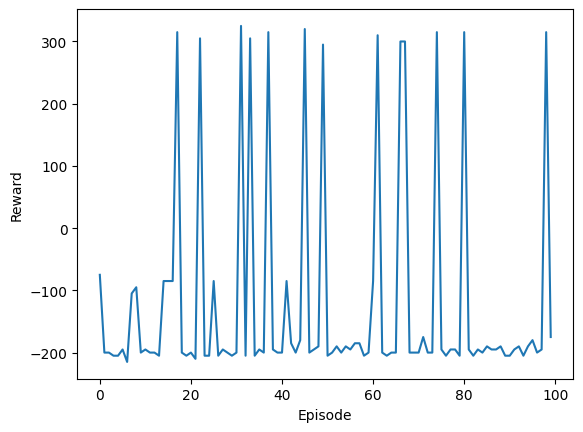

In [15]:
import matplotlib.pyplot as plt
plt.plot(total_reward)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

In [ ]:
from guppy import hpy
h = hpy()
print(h.heap())